# The Quantum Hall effect

In this project we are going to analyze the phenomenon of Hall conductivity quantization in the so-called Hall bar structure. This effect is a clear manifestation of the quantized Landau levels creation for electrons in the presence of the external magnetic field as well as the appearance of the so-called edge states.

### Preliminaries
The first step is to import libraries needed for the program.

In [1]:
import kwant
import numpy as np
from matplotlib import pyplot as plt
from scipy.constants import physical_constants
import ipywidgets as widgets
from ipywidgets import interact
from math import atan2, pi, sqrt
from kwant.digest import uniform

Next we define some physical constants needed to calculate contsants like **Effective Mass (m_eff)** or **standard hopping energy (t)**

In [2]:
h_bar = physical_constants['Planck constant over 2 pi'][0]  #J*s  
m_el = physical_constants['electron mass'][0]          #kg
eV_unit = physical_constants['electron volt'][0]      #J
hh = physical_constants['Planck constant'][0]  
el_charge = physical_constants['elementary charge'][0] 

# Define the lattice
a_m = 10*10**-9 # in meters
a = 10  # Lattice constant in nanometers
m_eff = 0.067*m_el
t_0 = (h_bar ** 2)/(2 * m_eff * a_m ** 2)
t = t_0/eV_unit
I = [0, 0, 0, 0, -1]

#T = 1 / (1 + ((2 * m_el * a**2 * I[0])/h_bar**2))

width = 600
length = 1200
cutout_width = 100
cutout_length = 240   
print(t)

0.005686540281567095


### Defining the lattice
To build the lattice system, we have to define several functions:
</br>
shape() -> defining the main shape of the system
</br> 
shape_lead() -> defining the length and shape of leads 4 and 5
</br> 
shape_lead_up() -> defining the length and shape of leads 0 and 1
</br> 
shape_lead_down() -> defining the length and shape of leads 2 and 3

In [3]:
sys = kwant.Builder()
lat = kwant.lattice.square(a)


y0 = 1000
x0 = 600

def shape(pos):
    x,y = pos
    if( (-length/2.0<=x<=length/2.0 and -width/2.0<=y<=width/2.0) or (-480 <= x <=-120 and 300<=y<=700) or (120 <= x <= 480 and -700 <= y <= -300) or (120 <= x <= 480 and 300 <= y <= 700) or (-480 <= x <=-120 and -700 <= y <= -300)):
        return True
    else:
        return False
    
    
def shape_lead(pos):
    x,y = pos
    if( -width/2.0<=y<=width/2.0 ):
        return True
    else:
        return False

def shape_lead_up(pos):
    x,y = pos
    if(400 <= y <= 700):
        return True
    else:
        return False
    
def shape_lead_low(pos):
    x,y = pos
    if(-700 <= y <= -400):
        return True
    else:
        return False
    
def hopping(site_i, site_j, B):
    xi,yi = site_i.pos
    xj,yj = site_j.pos
    
    C = 2*np.pi*B*el_charge*1e-18/hh
    return -t*np.exp(-0.5j * C * (yi+yj) * (xi-xj))

#U0 = 0.1 * t # the amplitude of the disorder potential 
#salt = 5 # how ”dense” the disorder is
#def onsite(site):
#    return U0 * (uniform(repr(site), repr(salt)) - 0.5) + 4 * t
                
#define impurities here
sys[lat.shape(shape, (0,0))] = 4*t
sys[lat.neighbors()] = hopping


lead_0 = kwant.Builder(kwant.TranslationalSymmetry((-a,0)))
lead_0[lat.shape(shape_lead_up, (0, 700))] = 4*t
lead_0[lat.neighbors()]= hopping

lead_1 = kwant.Builder(kwant.TranslationalSymmetry((a,0)))
lead_1[lat.shape(shape_lead_up, (0, 700))] = 4*t
lead_1[lat.neighbors()] = hopping

lead_2 = kwant.Builder(kwant.TranslationalSymmetry((-a,0)))
lead_2[lat.shape(shape_lead_low, (0, -700))] = 4*t
lead_2[lat.neighbors()]= hopping

lead_3 = kwant.Builder(kwant.TranslationalSymmetry((a,0)))
lead_3[lat.shape(shape_lead_low, (0, -700))] = 4*t
lead_3[lat.neighbors()] = hopping

lead_4 = kwant.Builder(kwant.TranslationalSymmetry((-a,0)))
lead_4[lat.shape(shape_lead, (0, 0))] = 4*t
lead_4[lat.neighbors()]= hopping

lead_5 = kwant.Builder(kwant.TranslationalSymmetry((a,0)))
lead_5[lat.shape(shape_lead, (0, 0))] = 4*t
lead_5[lat.neighbors()]= hopping

sys.attach_lead(lead_0)
sys.attach_lead(lead_1)
sys.attach_lead(lead_2)
sys.attach_lead(lead_3)
sys.attach_lead(lead_4)
sys.attach_lead(lead_5)

[]

### Hall Bar (all meassures in nanometers)

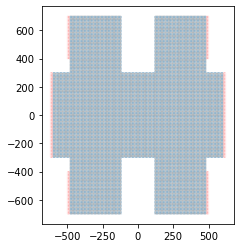

In [4]:
kwant.plot(sys);

In [5]:
# Finalize the system
sysf = sys.finalized()

Below we define the Fermi energry as well as vector **B_values** which defines the magnetic field range

In [6]:
ene = 0.004 # Fermi energy in eV
B_values = np.linspace(0.2, 0.5, 10) 
sigmaxx_arr = []
sigmaxy_arr = []

### Generating $\sigma_{xx}$ and $\sigma_{xy}$
The functions below calculate $\sigma_{xx}$ and $\sigma_{xy}$ (longitudinal and transverse conductivity) and assign their values to two respective arrays, for each element in B_value

In [7]:
def sigmaxx(sys, ene, bval):
    smatrix = kwant.smatrix(sys, ene, params=dict(B=bval))
    Gmat = np.transpose(smatrix.conductance_matrix())
    Gmat_del = np.delete(Gmat, 5, 0)
    Gmat_del = np.delete(Gmat_del, 5, 1)
    Gmat1 = np.linalg.inv(Gmat_del)
    V = np.dot(Gmat1, I)
    #np.linalg.solve(Gmat1[:-1, :-1], [0, 0, 0, 0, -1])
    R_L = (V[0] - V[1]) / I[4]
    R_H = (V[1] - V[3]) / I[4]
    sigma_xx = R_L / (R_L**2 + R_H**2)
    sigmaxx_arr.append(sigma_xx)
    return sigmaxx_arr

def sigmaxy(sys, ene, bval):
    smatrix = kwant.smatrix(sys, ene, params=dict(B=bval))
    Gmat = np.transpose(smatrix.conductance_matrix())
    Gmat_del = np.delete(Gmat, 5, 0)
    Gmat_del = np.delete(Gmat_del, 5, 1)
    Gmat1 = np.linalg.inv(Gmat_del)
    V = np.dot(Gmat1, I)
    #np.linalg.solve(Gmat1[:-1, :-1], [0, 0, 0, 0, -1])
    R_L = (V[0] - V[1]) / I[4]
    R_H = (V[1] - V[3]) / I[4]
    sigma_xy = R_H / (R_L**2 + R_H**2)
    sigmaxy_arr.append(sigma_xy)
    return sigmaxy_arr

We then call each function for length of the B_values times. So whatever we define the B_value length to be.

In [8]:
for B in B_values:
    sigmaxx(sysf, ene, B)
    #print(sigmaxx(sysf, ene, B))
    sigmaxy(sysf, ene, B)

In [9]:
print(sigmaxx_arr)
print(sigmaxy_arr)

[0.0004399405488722496, 6.987948640977588e-08, 1.5591278268442664e-12, 1.776356839400299e-15, -0.0, -1.360023205166004e-15, -0.0, 9.992007221626776e-16, 6.938893903907233e-16, -1.38777878078141e-15]
[11.999534570422112, 9.999999963552202, 8.999999999999236, 8.00000000000011, 6.999999999999982, 7.000000000000481, 6.000000000000073, 6.00000000000011, 5.000000000000002, 4.999999999999936]


## The Plots

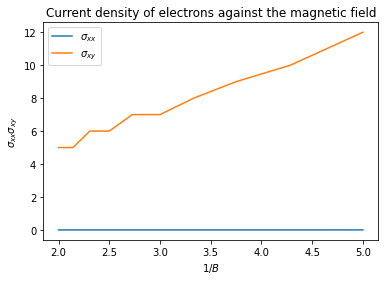

In [10]:
plt.title("Current density of electrons against the magnetic field")
plt.ylabel("$\sigma_{xx} \sigma_{xy}$")
plt.xlabel("$ 1 / B $")
plt.plot(1 / B_values, sigmaxx_arr, label = "$\sigma_{xx}$");
plt.plot(1 / B_values, sigmaxy_arr, label = "$\sigma_{xy}$");
plt.legend()

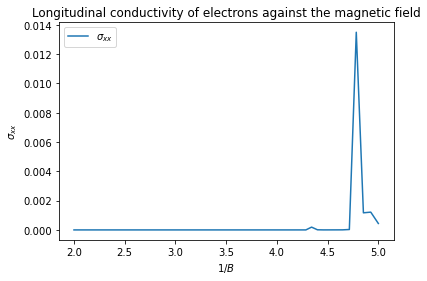

In [11]:
plt.title("Longitudinal conductivity of electrons against the magnetic field")
plt.ylabel("$\sigma_{xx}$")
plt.xlabel("$ 1 / B $")
plt.plot(1 / B_values, sigmaxx_arr, label = "$\sigma_{xx}$");
plt.legend()

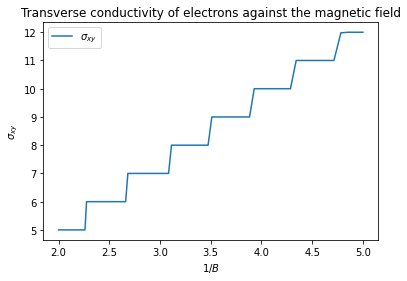

In [12]:
plt.title("Transverse conductivity of electrons against the magnetic field")
plt.ylabel("$\sigma_{xy}$")
plt.xlabel("$ 1 / B $")
plt.plot(1 / B_values, sigmaxy_arr, label = "$\sigma_{xy}$");
plt.legend()

### Wave Function

In [11]:
wfs = kwant.wave_function(sysf, ene, params = dict(B=B));

def plot_wf(n=0):
    scattering_wf = wfs(n);
    kwant.plotter.map(sysf, np.sum(abs(scattering_wf)**2, axis = 0));
    
    
interact(plot_wf, n=(0, 5));

interactive(children=(IntSlider(value=0, description='n', max=5), Output()), _dom_classes=('widget-interact',)…

## The system with impurities imposed

In [12]:
sys = kwant.Builder()
lat = kwant.lattice.square(a)


y0 = 1000
x0 = 600

def shape(pos):
    x,y = pos
    if( (-length/2.0<=x<=length/2.0 and -width/2.0<=y<=width/2.0) or (-480 <= x <=-120 and 300<=y<=700) or (120 <= x <= 480 and -700 <= y <= -300) or (120 <= x <= 480 and 300 <= y <= 700) or (-480 <= x <=-120 and -700 <= y <= -300)):
        return True
    else:
        return False
    
    
def shape_lead(pos):
    x,y = pos
    if( -width/2.0<=y<=width/2.0 ):
        return True
    else:
        return False

def shape_lead_up(pos):
    x,y = pos
    if(400 <= y <= 700):
        return True
    else:
        return False
    
def shape_lead_low(pos):
    x,y = pos
    if(-700 <= y <= -400):
        return True
    else:
        return False
    
def hopping(site_i, site_j, B):
    xi,yi = site_i.pos
    xj,yj = site_j.pos
    
    C = 2*np.pi*B*el_charge*1e-18/hh
    return -t*np.exp(-0.5j * C * (yi+yj) * (xi-xj))

# defining impurities
U0 = 1 * t # the amplitude of the disorder potential 
salt = 5 # how ”dense” the disorder is
def onsite(site):
    return U0 * (uniform(repr(site), repr(salt)) - 0.5) + 4 * t
                

sys[lat.shape(shape, (0,0))] = onsite
sys[lat.neighbors()] = hopping


lead_0 = kwant.Builder(kwant.TranslationalSymmetry((-a,0)))
lead_0[lat.shape(shape_lead_up, (0, 700))] = onsite
lead_0[lat.neighbors()]= hopping

lead_1 = kwant.Builder(kwant.TranslationalSymmetry((a,0)))
lead_1[lat.shape(shape_lead_up, (0, 700))] = onsite
lead_1[lat.neighbors()] = hopping

lead_2 = kwant.Builder(kwant.TranslationalSymmetry((-a,0)))
lead_2[lat.shape(shape_lead_low, (0, -700))] = onsite
lead_2[lat.neighbors()]= hopping

lead_3 = kwant.Builder(kwant.TranslationalSymmetry((a,0)))
lead_3[lat.shape(shape_lead_low, (0, -700))] = onsite
lead_3[lat.neighbors()] = hopping

lead_4 = kwant.Builder(kwant.TranslationalSymmetry((-a,0)))
lead_4[lat.shape(shape_lead, (0, 0))] = onsite
lead_4[lat.neighbors()]= hopping

lead_5 = kwant.Builder(kwant.TranslationalSymmetry((a,0)))
lead_5[lat.shape(shape_lead, (0, 0))] = onsite
lead_5[lat.neighbors()]= hopping

sys.attach_lead(lead_0)
sys.attach_lead(lead_1)
sys.attach_lead(lead_2)
sys.attach_lead(lead_3)
sys.attach_lead(lead_4)
sys.attach_lead(lead_5)

[]

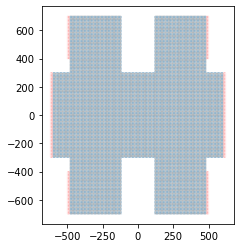

In [13]:
kwant.plot(sys);

In [14]:
# Finalize the system
sysf = sys.finalized()

In [15]:
ene = 0.004 # Fermi energy in eV
B_values = np.linspace(0.2, 0.5, 10)
sigmaxx_arr = []
sigmaxy_arr = []

In [16]:
def sigmaxx(sys, ene, bval):
    smatrix = kwant.smatrix(sys, ene, params=dict(B=bval))
    Gmat = np.transpose(smatrix.conductance_matrix())
    Gmat_del = np.delete(Gmat, 5, 0)
    Gmat_del = np.delete(Gmat_del, 5, 1)
    Gmat1 = np.linalg.inv(Gmat_del)
    V = np.dot(Gmat1, I)
    #np.linalg.solve(Gmat1[:-1, :-1], [0, 0, 0, 0, -1])
    R_L = (V[0] - V[1]) / I[4]
    R_H = (V[1] - V[3]) / I[4]
    sigma_xx = R_L / (R_L**2 + R_H**2)
    sigmaxx_arr.append(sigma_xx)
    return sigmaxx_arr

def sigmaxy(sys, ene, bval):
    smatrix = kwant.smatrix(sys, ene, params=dict(B=bval))
    Gmat = np.transpose(smatrix.conductance_matrix())
    Gmat_del = np.delete(Gmat, 5, 0)
    Gmat_del = np.delete(Gmat_del, 5, 1)
    Gmat1 = np.linalg.inv(Gmat_del)
    V = np.dot(Gmat1, I)
    #np.linalg.solve(Gmat1[:-1, :-1], [0, 0, 0, 0, -1])
    R_L = (V[0] - V[1]) / I[4]
    R_H = (V[1] - V[3]) / I[4]
    sigma_xy = R_H / (R_L**2 + R_H**2)
    sigmaxy_arr.append(sigma_xy)
    return sigmaxy_arr

In [17]:
for B in B_values:
    sigmaxx(sysf, ene, B)
    sigmaxy(sysf, ene, B)

In [18]:
print(sigmaxx_arr)
print(sigmaxy_arr)

[5.955912088413313, 5.658349569251226, 5.111874993257869, 4.689900443216488, 4.51644551405919, 1.7377564545211086, 4.144496691402478, 3.198331362204919, 4.431266573986651, 0.07092361353242366]
[6.290954877385194, 7.039821436872474, 6.884564719660236, 6.665317213025968, 5.375888864815658, 6.488179013345799, 5.373635210993012, 5.2825746212756295, 3.4806515404573153, 4.9734166936096145]


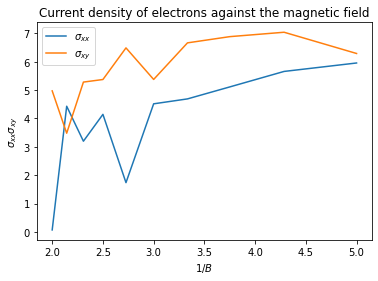

In [19]:
plt.title("Current density of electrons against the magnetic field")
plt.ylabel("$\sigma_{xx} \sigma_{xy}$")
plt.xlabel("$ 1 / B $")
plt.plot(1 / B_values, sigmaxx_arr, label = "$\sigma_{xx}$");
plt.plot(1 / B_values, sigmaxy_arr, label = "$\sigma_{xy}$");
plt.legend()

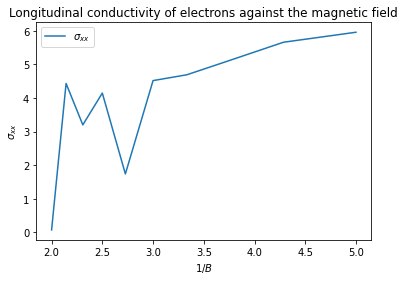

In [20]:
plt.title("Longitudinal conductivity of electrons against the magnetic field")
plt.ylabel("$\sigma_{xx}$")
plt.xlabel("$ 1 / B $")
plt.plot(1 / B_values, sigmaxx_arr, label = "$\sigma_{xx}$");
plt.legend()

In [ ]:
plt.title("Transverse conductivity of electrons against the magnetic field")
plt.ylabel("$\sigma_{xy}$")
plt.xlabel("$ 1 / B $")
plt.plot(1 / B_values, sigmaxy_arr, label = "$\sigma_{xy}$");
plt.legend()

In [ ]:
wfs = kwant.wave_function(sysf, ene, params = dict(B=B));

def plot_wf(n=0):
    scattering_wf = wfs(n);
    kwant.plotter.map(sysf, np.sum(abs(scattering_wf)**2, axis = 0));
    
    
interact(plot_wf, n=(0, 5));

## Conclusions

In this project we have succesfully calculated longitudinal and transverse conductivity. Using a magnetic field perpendicular to the system. 

#### interpretations
Through plots we could have observed, how as the magnetic field increased, the electron flow patterns changed and the transverse conductivity increased.
</br>
</br>
The conductivities exhibited the characteristic plateaus in $\sigma_{xy}$ and corresponding drops in $\sigma_{xx}$, which are signatures of the Quantum Hall Effect.

#### Effect of impurities

Introducing impurities into the system changed the behavior of the conductivities. When we increase the level of impurities, the conductance matrix and the resulting $\sigma_{xx}$ and $\sigma_{xy}$ values were affected.
</br>
</br>
Despite the impurities causing more electron scattering, the overall quantized nature of the Hall conductivity was preserved. This shows that the Quantum Hall Effect can withstand some level of disorder.

### Summary
The quantization of Hall conductivity, the resilience of edge states, and the impact of impurities were key observations that aligned well with theoretical expectations and experimental results documented in the project description and literature.